# Speculative Sampling(投机采样SpS)

references:
- [Accelerating Large Language Model Decoding
with Speculative Sampling](https://arxiv.org/pdf/2302.01318.pdf) by DeepMind
- [Fast Inference from Transformers via Speculative Decoding](https://arxiv.org/pdf/2211.17192.pdf) by Google
- [Accelerating Transformer Inference for Translation via Parallel Decoding](https://arxiv.org/pdf/2305.10427.pdf)
- [Draft & Verify: Lossless Large Language Model Acceleration via Self-Speculative Decoding](https://arxiv.org/pdf/2309.08168.pdf)



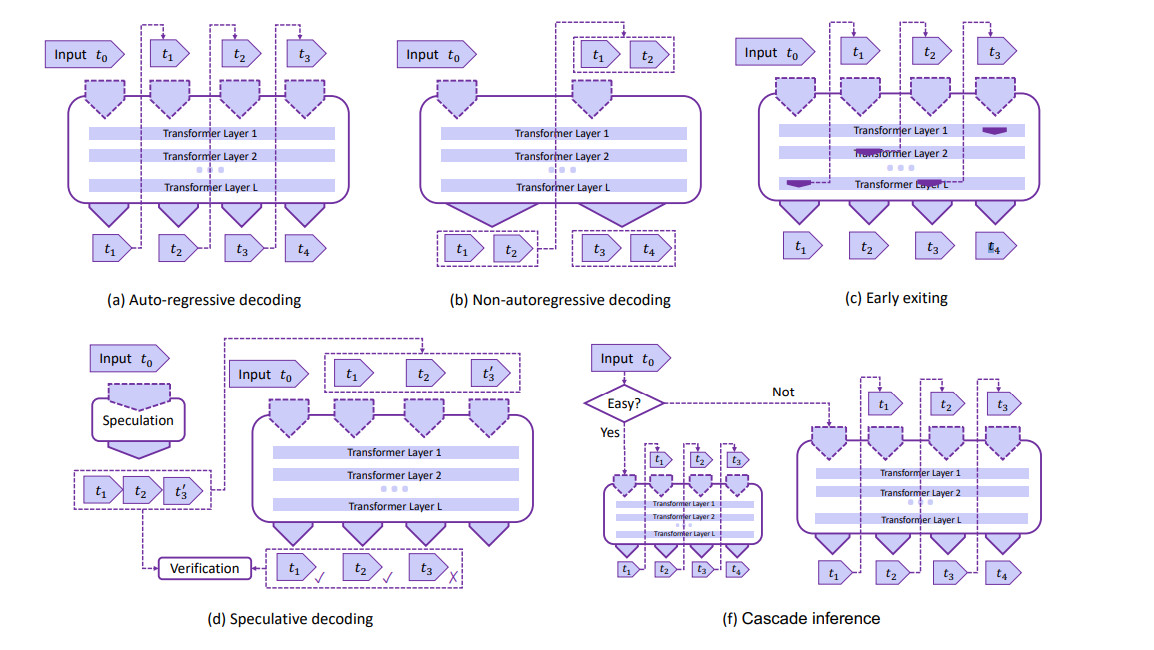

## Accelerating Large Language Model Decodingwith Speculative Sampling

观察到比原始大模型更小，推理速度更快的的draft model生成短句的时候和原始模型相当，并在此提出投机采样的算法，获得了性能2-2.5x的提升。

步骤如下：
1. 使用更快的draft模型生成长度K的draft短句
2. 使用更大，精度更好的大模型target模型来对生成的draft进行评分
3. 使用修改后的拒绝式采样策略，从左至右接受长度K的draft子集。并恢复target模型的分布。

如果draft模型和target模型在子序列上生成的tokens相同的分布，那么使用draft模型可以生成多倍的tokens相比target模型。

算法伪代码如下：

![image.png](attachment:image.png)

从直觉上来说，draft model是很重要的，因为最终能够减少多少的推理延迟以及生成出来的draft短句的acceptance rate有直接影响。

所以对于draft 模型有如下的选择方法：

- 将draft模型整合到target模型中，并从头开始训练
- 利用蒸馏来生成第二个模型
- 将target模型的部分激活作为draft模型的输入，并且使用这个输入来训练模型

然而以上方法存在显著的问题，需要额外的开销去训练draft模型，成本太大。

当然还可以使用大模型的次级模型作为draft模型，比如以llama 30b为target 模型，可以使用llama 7b为draft模型。

论文中使用从头开始训练了4B的draft模型，target模型则为70B Chinchilla，4B 模型1.8ms/token, 70B模型 14.1ms/token

## Fast Inference from Transformers via Speculative Decoding

论文中观察到来自大型模型的推理通常不是在算术操作上形成瓶颈，而是在内存带宽和通信方面，因此可能有额外的计算资源可用。

因此论文建议增加模型的并发性作为一个方法来提速，而无需更改模型的架构以及重新训练模型。

论文提出了 speculative sampling 和 speculative decoding

https://github.com/feifeibear/LLMSpeculativeSampling


## Accelerating Transformer Inference for Translation via Parallel Decoding

自回归方式解码限制了Machine Translation的性能，通常为了提升性能而改变模型结构使得能够并行从而降低精度。

论文提出了一种利用Jacobi 和Gauss-Seidel 定点迭代的方式并行加速贪心自回归，这种方法不需要训练和修改的情况下加速现有的模型，同时保证了精度。

MT 的目标是将 语句 x 翻译为另外一种语言的语句 y。

这里使用 $x = {x_1, ..., x_n}$ 和 $y = {y_1, ..., y_m}$ 来表示语句中的token。

MT模型的估计条件概率 $p_{\theta}(y|x)$, 而在模型推理阶段则是根据概率计算下一个token的概率$p_{\theta}(y_i|y_1, ..., y_{i-1}, x) \ \ \ Eq.1$, 现有的采样的策略有贪心，top_k, top_p，而其中最中介的方法则是贪心搜索。

贪心搜索的估计公式为 $y_i = argmax\ p_{\theta}(y_i|y_{1:{i-1}}, x) \ \ \ Eq.2$

标准的自回归模式下推理 m step 输出m个tokens, 根据Eq.2 可以得到如下公式:

$$
\begin{align}
f(x)=
\begin{cases}
y_1 &= argmax\ p_{\theta}(y_1|x)\\
y_2 &= argmax\ p_{\theta}(y_2|y_1,x) \\
...\\
y_m &= argmax\ p_{\theta}(y_m|y_1:y_{m-1},x)
\end{cases}  \ \ Eq.3
\end{align}
$$

现在使得 $f(y_i, y_{1: {i-1}}, x) = y_i - argmax\ p_{\theta}(y_i|y_1:y_{i-1}, x)$，就可以得到如下的公式

\begin{align}
\begin{cases}
f(y_1, x) = 0\\
f(y_2, y1, x) = 0 \\
...\\
f(y_m, y_{1:{m-1}}, x ) = 0
\end{cases}  \ \ Eq.4
\end{align}
$$

则整个系统就可以描述为一个具有m个变量的非线性等式。

自回归解码就是隐式的在求解 Eq.4.  本文利用Jacobi和Gauss-Seidel 定点迭代法来求解上述问题。


### Parallel Jacobi(PJ) Decoding

论文提出来的算法1， 该算法通过初始化整个句子的draft翻译，然后迭代的并行翻译整个句子，直到触发停止条件，因使用的Jacobi方法而命名。

### Parallel GS-Jacobi(PGJ) Decoding

并行解码整个目标句子可能会引入推导长序列之间的依赖关系困难，同时也发现到依赖较短的关系更容易预测，因此并行解码并不是整个句子，而是将句子分隔成的b-维块，从第一个块开始，并行解码所有元素，一旦一个块完成块或块内的停止条件被处罚，算法执行下一次Gauss-Seidel step，在下一个块上解码，因此这个方法被称为GS-Jacobi解码。

### Hybrid GS-Jacobi(HGJ) Decoding

算法1 和算法2 都是基于已经预先知道要生成多少长的token，即m的值已知。而真实情况下m的长度是不可预知的，文本的结束通过EOS来控制。

该算法使用GS-Jacobi decoding一个定长h，如果EOS 在定长h内出现，那么算法则停止。返回到EOS之前的解码结果。

解码算法主要分为两步：
1. 初始化INIT(x).
2. 停止条件 STOPC($y^{k-1}$, $y^{k}$), 当$y^{k-1} - y^k = 0$.

命题1. 上述算法1、2、3最多进行m个并行迭代后收敛，并且产生和gready 自递归解码相同的结果，无论初始条件是什么。

参考文献：Yang Song, Chenlin Meng, Renjie Liao, and Stefano
Ermon. 2021b. Accelerating feedforward computation via parallel nonlinear equation solving. In International Conference on Machine Learning, pages
9791–9800. PMLR.






## Draft & Verify: Lossless Large Language Model Acceleration via Self-Speculative Decoding

提出了一种不需要额外训练，也不需要额外的内存使用能够加速达到1.73x的自投机采样。

Trasformer主要的性能瓶颈在于自回归的解码过程中，这个过程中不断的调用transformer，而每次transformer调用都因为memory bound，导致了计算效率低下，因此需要更长的运行时间。

而投机解码则是为了加速解码，通过训练一个draft模型来快速生成序列，而大模型只要一次前向传递就可以检查这些draft模型生成的token哪些是可以接受的。 而训练draft模型则是开销比较大，本文主要提出了使用一个LLM同时能够作为draft以及检查，根据观察到跳过大模型的某些层并不会影响到大模型的精度，因此有选择旁路掉一下decoder layer 可以得到一个draft模型。

论文选择使用LLaMA-2-13B, LLaMA-2-13B-Chat,CodeLLaMA-13B, and LLaMA-2-70B 作为试验对象。

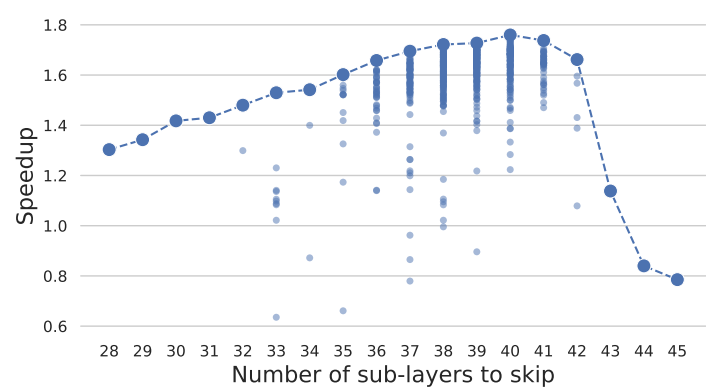

蓝色箭头为原始target模型的推理路径，而绿色箭头则是筛选出来的层作为draft 模型。

所以实现Self-Speculative Decoding 的挑战在如下方面：

- 决定哪些层要跳过
- 如何选择K 来使用target 模型检查生成的概率，如下图所示，K的选择也影响到最终的加速效果

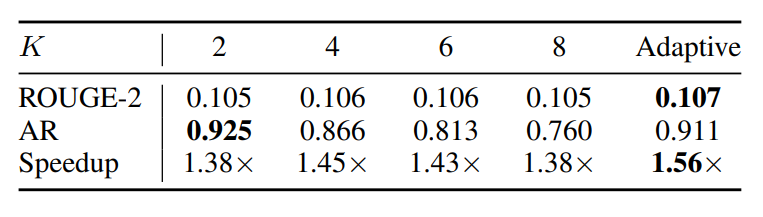

K的选择和accpetance rate相关，模型的accpetance rate 小于80%的时候K为1是最优的，当accpetance rate大于80%的时候，K要选择大于1，所以静态的K取值是不可取的。所以当draft模型生成出来的token 置信度低于某一门限时，则选择使用target模型来检查。

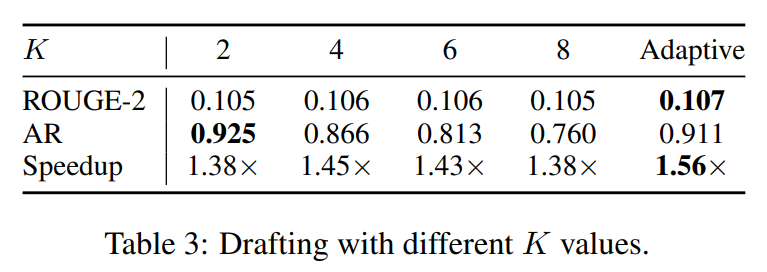

最终获得模型加速效果如下：
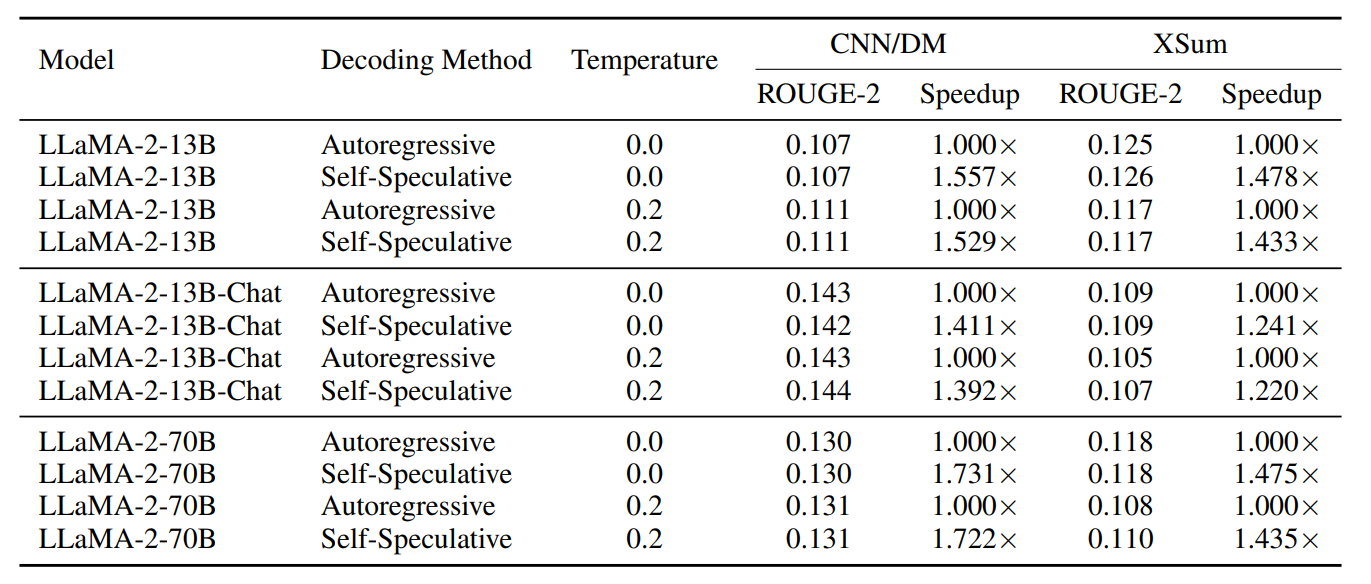

### 挑战1 如何决定哪些层需要跳过

通过暴力搜索可以实现全局的最优选择，但是以LLama-2-70B为例，就存在L=160，这样搜索下来的成本相当大。

而基于这个结论，Bayesian optimization 就可以解决这个问题。

以LLaMA-2-13B为例

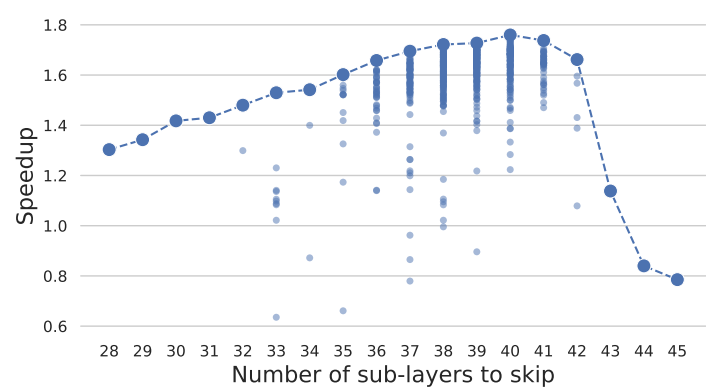

当跳了1半层的时候，达到了最高加速率，当跳的层数达到42层，加速率显著下降，说明模型的acceptance rate显著降低。

### 挑战2 何时退出draft模型生成而使用target模型评估，即K的选择

这里分别试验了三种方案：

1. 不同定长K下的性能加速效果
2. 定长K下，带门限置信度阈值情况下的加速效果
3. 适应性门门限下的加速效果

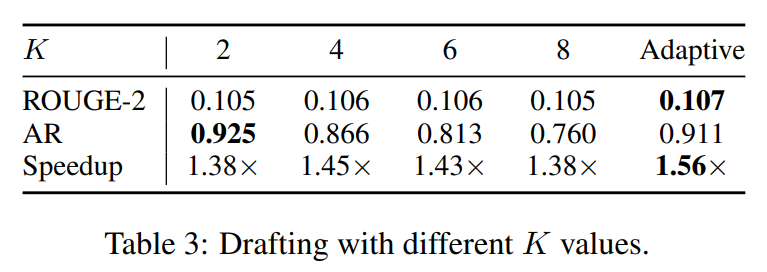

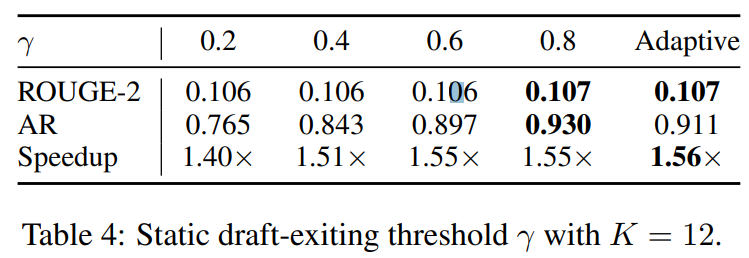


这里可以看到 三种方案中，方案2和方案3都获得了相当好的效果，而最终作者认为方案3更好的原因是，方案2 不断的搜索这个阈值来达到较好的效果。而搜索到这个阈值来获得较高的加速效果也是比较耗时的。

https://github.com/dilab-zju/self-speculative-decoding



## Projects

- [Medusa blog](https://sites.google.com/view/medusa-llm) [Medusa github](https://github.com/FasterDecoding/Medusa)

### Medusa



